In [ ]:
"""
TODOs:
Build a graph where nodes are master tags, and edges are relational strength between two tags 
(for example, np-array and np-matrix as two individual tags that are highly coorelated with one another). 
As a measure of strength between tags, see cosine similiarity. 
Since there are a constant number of tags (roughly 6000), represent the graph as an adjacency matrix.

Notes:
https://tinyurl.com/y9hcxglo
"""

In [2]:
import pandas as pd
from collections import Counter, defaultdict
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
PATH = '/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/300000_rows/'
QUESTION = 1
ANSWER = 2
UP = 2
DOWN = 3
path = lambda x: PATH + x

In [2]:
posts = pd.read_csv(path('Posts.csv'))
votes = pd.read_csv(path('Votes.csv'))

/Users/John/Dropbox/ECS171/HW3/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
posts['ParentID'] = posts['ParentID'].fillna(0).astype(int)
posts['AcceptedAnswerId'] = posts['AcceptedAnswerId'].fillna(0).astype(int)

### What is the ratio of questions left answered?

In [ ]:
questions = posts[posts['PostTypeId'] == QUESTION]
unanswered = questions[questions['AcceptedAnswerId'] == 0]
#len(questions[questions['AnswerCount'] == 0]) / len(questions)

### What is the ratio of questions without an accepted answer?

In [ ]:
len(unanswered) / len(questions)

In [ ]:
unanswered.rename(columns = {'Id':'PostId'}, inplace = True)
upvotes = votes[votes['VoteTypeId'] == UP]

In [ ]:
no_ans_q = questions[questions['AnswerCount'] == 0]
no_ans_q.rename(columns = {'Id':'PostId'}, inplace = True)
uv_no_ans = upvotes.join(no_ans_q.set_index('PostId'), on='PostId', how='inner', lsuffix='_x')

In [ ]:
# List the 15 most upvoted questions that are unanswered.
top_uv_no_ans = Counter(uv_no_ans['PostId']).most_common(15)

### List the 15 most upvoted questions that are unanswered.

In [ ]:
unanswered.sort_values(by='Score',ascending=False)[:15]

In [ ]:
posts['CreationDate'] = pd.to_datetime(posts.CreationDate)
#posts.sort_values(by='CreationDate')[:10]

### What is the mean and median response for a question for each of the 20 most popular tags?
The mean and median response is the difference between when the question is asked and when the first answer is. 

In [ ]:
tags = pd.read_csv('/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/tags/tag_distribution.csv')

In [ ]:
top_tags = tags.sort_values(by='frequency', ascending=False)[:20]

#### Getting the time between the question is asked and the accepted answer 

In [ ]:
answers = posts[posts['PostTypeId'] == ANSWER] 
def time_diff(question_row):
    answer_row = answers.loc[answers['Id'] == question_row['AcceptedAnswerId']]
    return answer_row.get_value(answer_row.index.values[0], 'CreationDate') - question_row.get_value(4)

In [ ]:
questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])

In [ ]:
answered_questions = questions[questions['AcceptedAnswerId'] != 0]
answered_questions['AcceptedAnswerTime'] = answered_questions.apply(time_diff, axis=1)

In [ ]:
tag_dict = json.load(open('/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/tag_network_load.json'))

In [ ]:
# tag with accepted answer time in hours
post_by_tags = pd.DataFrame(columns=list(top_tags['tag']))
for tag in top_tags['tag']:
    rows = answered_questions.loc[posts['Id'].isin(tag_dict[tag])]
    # convert to hours
    post_by_tags[tag] = rows['AcceptedAnswerTime'].apply(lambda x: x.seconds / 3600)

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
mean_responses = post_by_tags.mean().sort_values()
sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="Tags", ylabel="Time in Hours",fontsize=16)
ax = sns.boxplot(x=mean_responses.axes[0].values, y=list(mean_responses),palette="Set3")
ax.set_title('Top 20 Tags Mean Accepted Answer Response Time')
plt.show()

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
median_responses = post_by_tags.median().sort_values()
sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="Tags", ylabel="Time in Hours",fontsize=16)
ax = sns.boxplot(x=median_responses.axes[0].values, y=list(median_responses),palette="Set3")
ax.set_title('Top 20 Tags Median Accepted Answer Response Time')
plt.show()

## Tag Network

https://trello.com/c/kxI21E3n

In [14]:
tags = pd.read_csv('/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/tags/tag_distribution.csv')
tag_dict = json.load(open('/Users/John/Dropbox/160-Stackoverflow-Data/tags/tag_index_network.json'))

In [ ]:
# store the cosine(tag1, tag2)
n = 100
tag_similarity = pd.DataFrame([],columns=all_tags[:n], index=all_tags[:n])

def cosine_sim(tag1, tag2, tag_dict):
    tag1_set = set(tag_dict[tag1])
    tag2_set = set(tag_dict[tag2])
    num =  len(tag1_set & tag2_set)
    den = (len(tag1_set)**2)**5 * (len(tag2_set)**2)**.5
    return num / den 

for i in range(n-1):
    tag1 = all_tags[i]
    for j in range(i+1, n-1):
        tag2 = all_tags[j]
        tag_similarity.at[tag1,tag2] = cosine_sim(tag1, tag2, tag_dict)
        
def build_graph():
    graph = defaultdict(dict)
    for i in range(n):
        tag = all_tags[i]
        similar_tags = tag_similarity.loc[tag,:].nlargest(n=15)
        
        graph[tag] = {'similar_tags' : [(a, b) for a, b in zip(similar_tags.axes[0].tolist(), similar_tags.values.tolist())\
                                       if b > 0]}
    return graph

tag_similarity = tag_similarity.astype(float)
graph = build_graph()

import json
with open('tag_network.json', 'w+') as outfile:
    json.dump(graph, outfile)

In [7]:
with open('/Users/John/Dropbox/160-Stackoverflow-Data/tags/tag_network.json') as json_file:
    graph = json.load(json_file)

In [ ]:
tag_dict = json.load(open('/Users/John/Dropbox/160-Stackoverflow-Data/tags/tag_index_network.json'))

In [3]:
users = pd.read_csv(path('Users.csv'))

In [4]:
users.head()

,Id,Reputation,CreationDate,DisplayName,EmailHash,LastAccessDate,WebsiteUrl,Location,Age,AboutMe,Views,UpVotes,DownVotes
0,9169319,1,2018-01-03T17:30:02.617,Robert Kirkwood,NaN,2018-01-03T21:47:46.450,NaN,NaN,NaN,NaN,0,0,0
1,9169320,1,2018-01-03T17:30:06.987,nirmpate,NaN,2018-02-16T15:12:18.370,NaN,NaN,NaN,NaN,0,0,0
2,9169321,1,2018-01-03T17:30:35.420,Raphael Pinheiro,NaN,2018-01-04T19:47:26.713,NaN,"Curitiba - PR, Brasil",NaN,NaN,0,0,0
3,9169322,1,2018-01-03T17:31:00.230,Mohanad AL Ansary,NaN,2018-01-03T17:31:00.230,NaN,Sudan,NaN,NaN,0,0,0
4,9169323,1,2018-01-03T17:31:36.103,Karina Grzeszkiewicz,NaN,2018-01-08T20:35:14.267,NaN,NaN,NaN,NaN,0,0,0


In [10]:
users = pd.read_csv('/Users/John/Dropbox/160-Stackoverflow-Data/train_test/Users.csv')
posts = pd.read_csv('/Users/John/Dropbox/160-Stackoverflow-Data/train_test/X.csv')

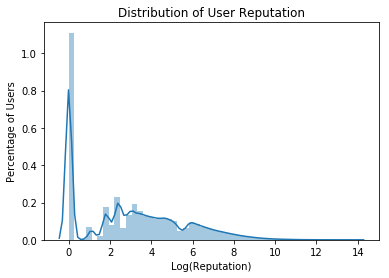

In [14]:
fig = sns.distplot(users['Reputation'].dropna()))
fig.set(title="Distribution of User Reputation", xlabel='Log(Reputation)', ylabel='Percentage of Users')
plt.show()

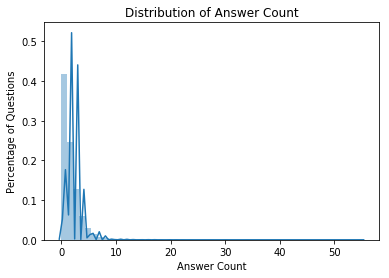

In [19]:
fig = sns.distplot(posts['AnswerCount'].dropna())
fig.set(title="Distribution of Answer Count", xlabel='Answer Count', ylabel='Percentage of Questions')
plt.show()

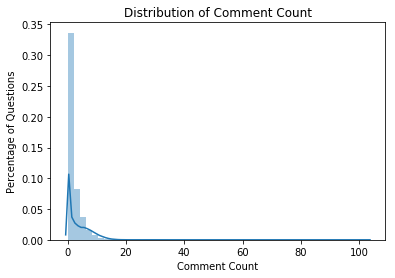

In [20]:
fig = sns.distplot(posts['CommentCount'].dropna())
fig.set(title="Distribution of Comment Count", xlabel='Comment Count', ylabel='Percentage of Questions')
plt.show()

In [21]:
len(posts[posts['AnswerCount'] == 0]) / len(posts)

0.04779663757438567